In [2]:
import os
import numpy as np
import pandas as pd
import shap
from pandas import read_csv, get_dummies, Series
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [36]:
# Path to the CSV file in the sub-directory
file_path = "../data/bank-additional/bank-additional-full.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=";")

#Check the top five rows in the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
#### Let's explore the shape of the dataset
df.shape

(41188, 21)

# Data Preparation and Cleaning

In [38]:
# Checking the data types 
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [39]:
''' Creating a list of the categorical features '''
cat_cols = []
for i in df:
     if df[i].dtypes == 'object':
        cat_cols.append(i)

In [40]:
''' Creating a list of the continuous features '''
cont_cols = []
for i in df:
    if df[i].dtypes == 'int64' or df[i].dtypes == 'float64':
        cont_cols.append(i)

#### Checking for NaN and null values in the continuous variables

In [41]:
for k in cont_cols:
    print(k, ":", df[k].isnull().sum())


age : 0
duration : 0
campaign : 0
pdays : 0
previous : 0
emp.var.rate : 0
cons.price.idx : 0
cons.conf.idx : 0
euribor3m : 0
nr.employed : 0


#### Let's find out the number of classes in each categorical feature

In [42]:
for k in cat_cols:
    print(k, ":", df[k].nunique())

job : 12
marital : 4
education : 8
default : 3
housing : 3
loan : 3
contact : 2
month : 10
day_of_week : 5
poutcome : 3
y : 2


In [43]:
# Let's print out the number of classes in each categorical feature
for k in cat_cols:
    print(k, ":", df[k].unique(), '\n')
   

job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

marital : ['married' 'single' 'divorced' 'unknown'] 

education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

default : ['no' 'unknown' 'yes'] 

housing : ['no' 'yes' 'unknown'] 

loan : ['no' 'yes' 'unknown'] 

contact : ['telephone' 'cellular'] 

month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

day_of_week : ['mon' 'tue' 'wed' 'thu' 'fri'] 

poutcome : ['nonexistent' 'failure' 'success'] 

y : ['no' 'yes'] 



In [44]:
## Check for Duplicates
df.duplicated().sum()

12

In [45]:
#Remove duplicates
df = df.drop_duplicates()

## There are no missing values, but we have some entries with 'unknown' which we would remove

In [46]:
## Check for missing data (including rows containing 'unknown' as entries)

def checkNulls(input_df: pd.DataFrame) -> pd.DataFrame:
    ''' Given a DataFrame, generate a column-wise summary of the number of
    missing entries.
    '''
    missing_df = pd.DataFrame(input_df.isnull().sum(axis=0), columns=['Num_Nulls']).reset_index()
    missing_df.columns = ['Column_Name', 'Num_Nulls']
    missing_df = missing_df[missing_df['Num_Nulls'] != 0]
    if len(missing_df) > 0:
        return missing_df
    else:
        return 'There are no missing or null values in the data'

In [47]:
checkNulls(df)

'There are no missing or null values in the data'

#### There are other instances of missing entries in the form of 'unknown'

In [48]:
unknown_entries = df.isin(['unknown']).sum(axis=0)
unknown_entries[unknown_entries > 0]

job           330
marital        80
education    1730
default      8596
housing       990
loan          990
dtype: int64

In [49]:
sum(unknown_entries[unknown_entries > 0])

12716

## Remove Unknown Values

In [50]:
df_copy = df.copy()

In [51]:
# List of columns to check for "unknown" values
columns_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan']

In [52]:
# Filter out rows containing "unknown" values in any of the specified columns
df_cleaned = df_copy[~df_copy[columns_to_check].apply(lambda row: 'unknown' in row.values, axis=1)]


In [53]:
df_cleaned.shape

(30478, 21)

In [54]:
unknown_entries = df_cleaned.isin(['unknown']).sum(axis=0)
unknown_entries[unknown_entries > 0]

Series([], dtype: int64)

## Delete df at this stage

In [56]:
#del(df)

## Rename target variable to something meaningful

In [57]:
df_cleaned.rename(columns={'y': 'subscription'}, inplace=True)
df_cleaned.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscription
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Save the cleaned dataset for modelling

In [58]:
#df_cleaned.to_csv('df_cleaned.csv', index=False)

In [ ]:
# Read in cleaned data 

In [3]:
# # Path to the CSV file in the sub-directory
# file_path = "archive/df_cleaned.csv"

# # Read the CSV file into a DataFrame
# df_cleaned = pd.read_csv(file_path, sep=",")

In [4]:
df = df_cleaned.copy()

In [5]:
df.shape

(30478, 21)

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscription
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Data Analysis

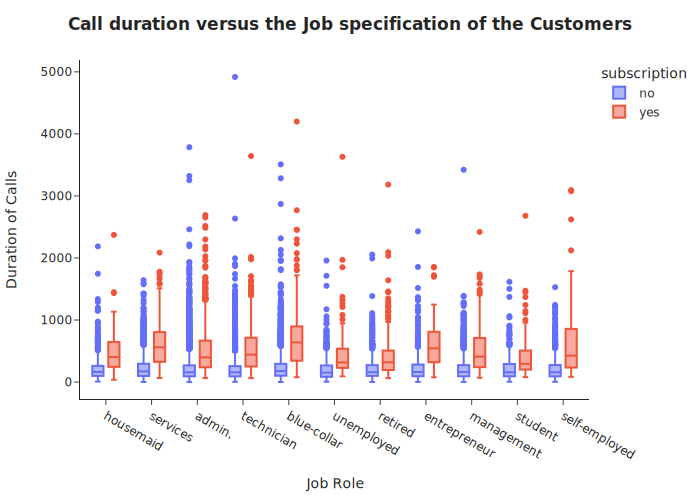

In [9]:
fig = px.box(df, x="job", y="duration", color="subscription")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

# Update the layout to include a title
fig.update_layout(
    title='<b>Call duration versus the Job specification of the Customers</b>',
    xaxis_title='Job Role',
    title_x=0.5,
    yaxis_title='Duration of Calls',
      template='simple_white'
)

fig = go.Figure(fig)
# Save the figure as a PDF file
#pio.write_image(fig, 'EDA/call_job.pdf')
fig.show("svg")

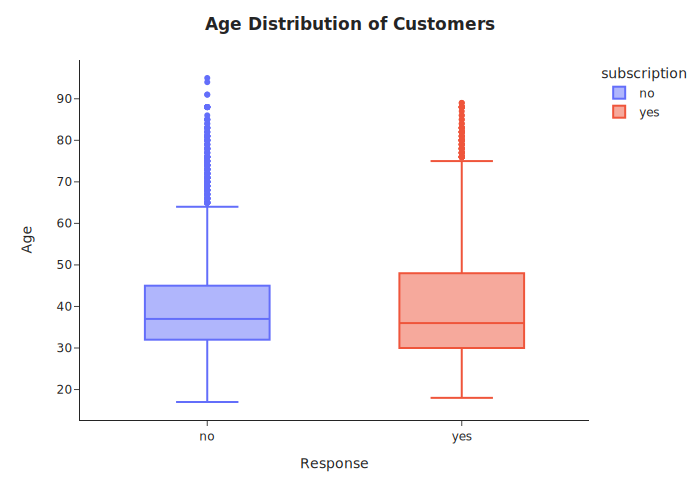

In [10]:
fig = px.box(df, x="subscription", y="age", color="subscription")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default

# Update the layout to include a title
fig.update_layout(
    title='<b>Age Distribution of Customers</b>',
    xaxis_title='Response',
    title_x=0.5,
    yaxis_title='Age',
      template='simple_white'
)

fig = go.Figure(fig)
# Save the figure as a PDF file
#pio.write_image(fig, 'EDA/age_dist.pdf')
fig.show("svg")

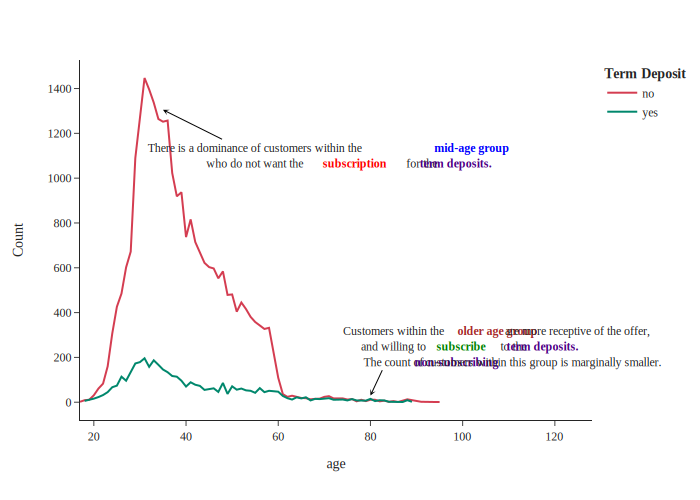

In [11]:
import plotly.express as px

# Create the line plot
fig = px.line(df.groupby(['age', 'subscription'], as_index=False)['job'].count().rename(columns={'job': 'Count'}),
              x='age', y='Count', color='subscription', template='simple_white', color_discrete_sequence=['#d43d51', '#00876c'])

# Update layout with centered title
fig.update_layout(title_x=0.5, font_family="Times New Roman", legend_title_text="<b>Term Deposit</b>",
                  title_text='<b style="font-family: Times New Roman; font-size:1.3vw">Influence of Age on Term Deposits</b>')

# Annotations for additional insights
fig.add_annotation(
    x=35,
    y=1305,
    ax=55,
    ay=1100,
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text='There is a dominance of customers within the <b style="color: Blue;">mid-age group</b> <br> who do not want the <b style="color: red;">subscription </b> for the  <b style="color: Indigo;"> term deposits.</b>',
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=1,
    arrowcolor='black'
)

fig.add_annotation(
    x=80,
    y=30,
    ax=85,
    ay=250,
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text='Customers within the <b style="color: Brown;">older age group</b> are more receptive of the offer, <br> and willing to <b style="color: Green;">subscribe </b> to the <b style="color: Indigo;">term deposits.</b> <br> The count of <b style="color: Indigo;">non-subscribing </b>customers within this group is marginally smaller.',
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=1,
    arrowcolor='black'
)

#pio.write_image(fig, 'EDA/age_influence.png')

# Show the figure
fig.show("svg")


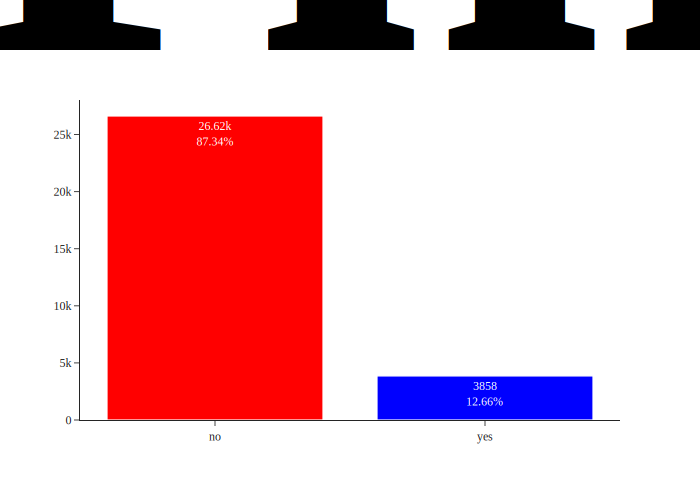

In [12]:
import plotly.graph_objects as go

# Define the colors for 'yes' and 'no'
yes_color = '#0000ff'
no_color = '#ff0000'

fig = go.Figure()

# Calculate the total count for percentage calculation
total_count = df['subscription'].count()

# Bar chart for Subscription
fig.add_trace(go.Bar(
    x=df['subscription'].value_counts().index,
    y=df['subscription'].value_counts(),
    marker_color=[no_color, yes_color],  # Assign colors to 'no' and 'yes'
    name='no',  # Match the label in your dataset
    texttemplate='%{y}<br>%{text}',  # Template for displaying y (count) and text (percentage)
    text=[f'{(count/total_count)*100:.2f}%' for count in df['subscription'].value_counts()]
))

fig.update_layout(
    title_text='<b style="color:black; font-size:105%;">Distribution of the Term Deposit Subscription</b>',
    font_family="Times New Roman", title_font_family="Times New Roman",
    title_x=0.5,
#     legend_title_text='Subscription',  # Set the legend title
#     legend_traceorder='normal',  # Keep the order as added
#     showlegend=True,
    template='simple_white'
)

# Update the appearance of bars
fig.update_traces(marker_line=dict(color='white', width=1.2))
#fig_bar.write_image("EDA/tar_col.pdf")
fig.show("svg")


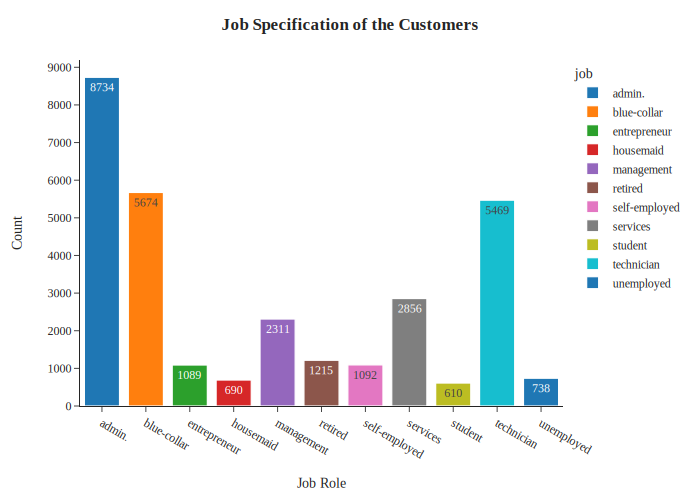

In [14]:
# Let us group the customers by their job roles
job_counts = df.groupby('job').size().reset_index(name='Count')

# Create the bar chart
fig = px.bar(
    job_counts,
    x='job',
    y='Count',
    color='job',
    text='Count',
    template='simple_white'
)

fig.update_traces(marker=dict(line=dict(color='white', width=1.2)))

fig.update_layout(
    title='<b>Job Specification of the Customers</b>',
    title_x=0.5,
     xaxis_title='Job Role',
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    )

fig = go.Figure(fig)
# Save the figure as a PDF file
#pio.write_image(fig, 'EDA/jobtype_count.pdf')

fig.show("svg")

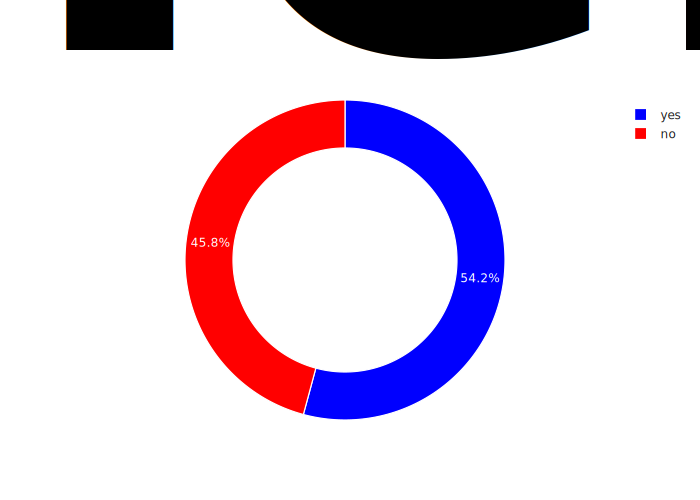

In [15]:
yes_color = '#ff0000'
no_color = '#0000ff'
unknown = '#008000'
fig = go.Figure()

# Pie chart for Housing Loan
fig.add_trace(go.Pie(
    values=df['housing'].value_counts(),
    labels=df['housing'].value_counts().index,
    hole=0.7,
    marker_colors=[no_color, yes_color,unknown],  # Assign colors to 'no' and 'yes'
    name='Housing Loan'
))

fig.update_layout(
    title_text='<b style="color:black; font-size:100%;">Distribution of Customers with Housing Loans</b>',
    title_x=0.5,
    showlegend=True,
    template='simple_white'
)

fig.update_traces(marker=dict(line=dict(color='white', width=1.2)))

fig = go.Figure(fig)
# Save the figure as a PDF file
#pio.write_image(fig, 'EDA/cust_housing_loans.pdf')

fig.show("svg")

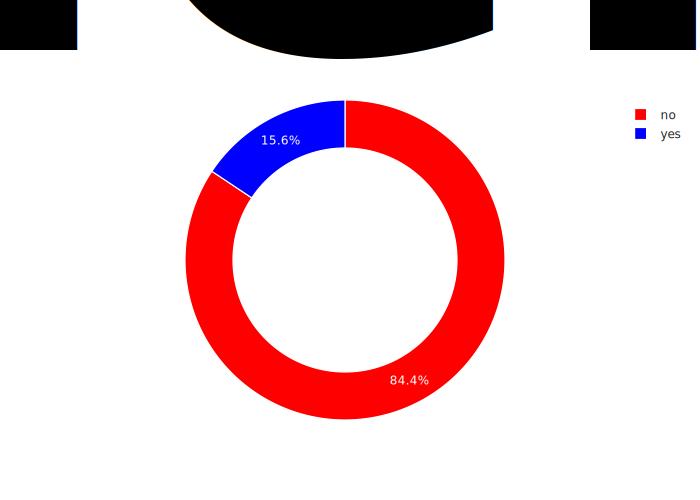

In [16]:
# Define the colors for 'yes' and 'no'
yes_color = '#0000ff'
no_color = '#ff0000'
unknown = '#008000'
fig = go.Figure()

# Pie chart for Personal Loan
fig.add_trace(go.Pie(
    values=df['loan'].value_counts(),
    labels=df['loan'].value_counts().index,
    hole=0.7,
    marker_colors=[no_color, yes_color,unknown],  # Assign colors to 'no' and 'yes'
    name='Personal Loan'
))

fig.update_layout(
    title_text='<b style="color:black; font-size:100%;">Distribution of Customers with Personal Loans</b>',
    title_x=0.5,
    showlegend=True,
    template='simple_white'
)

fig.update_traces(marker=dict(line=dict(color='white', width=1.2)))

fig = go.Figure(fig)
# Save the figure as a PDF file
#pio.write_image(fig, 'EDA/cust_with_loan.pdf')

fig.show("svg")

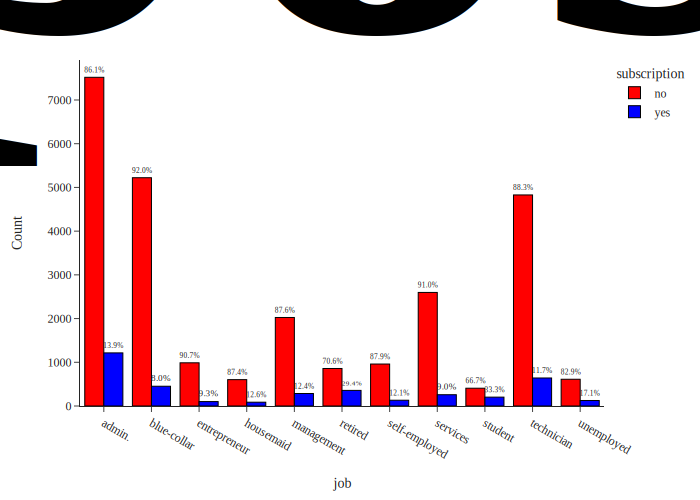

In [17]:
a = df.groupby(['job', 'subscription'], as_index=False)['age'].count().rename(columns={'age': 'Count'})
a['percent'] = round(a['Count'] * 100 / a.groupby('job')['Count'].transform('sum'), 1)
a['percent'] = a['percent'].apply(lambda x: '{}%'.format(x))

fig = px.bar(a, x='job', y='Count', text='percent', color='subscription', barmode='group', template='simple_white', color_discrete_map={'yes': '#0000ff', 'no': '#ff0000'})
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)), textposition="outside")
fig.update_layout(title_x=0.5, template='simple_white', showlegend=True, title_text='<b style="color:black; font-size:105%;">Distribution of Term Depositors Based on Job Roles</b>', font_family="Times New Roman", title_font_family="Times New Roman")

#pio.write_image(fig, 'EDA/cust_job_target.pdf')
fig.show("svg")

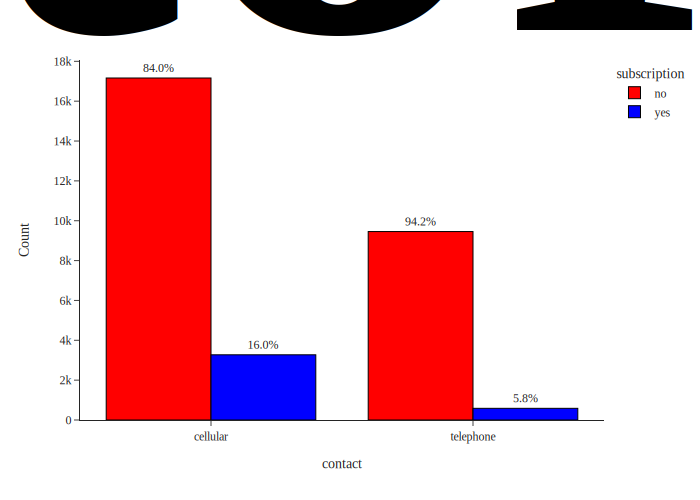

In [18]:
a = df.groupby(['contact', 'subscription'], as_index=False)['age'].count().rename(columns={'age': 'Count'})
a['percent'] = round(a['Count'] * 100 / a.groupby('contact')['Count'].transform('sum'), 1)
a['percent'] = a['percent'].apply(lambda x: '{}%'.format(x))

fig = px.bar(a, x='contact', y='Count', text='percent', color='subscription', barmode='group', 
             template='simple_white', color_discrete_map={'yes': '#0000ff', 'no': '#ff0000'})
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)), textposition="outside")
fig.update_layout(title_x=0.5, template='simple_white', showlegend=True, 
                  title_text='<b style="color:black; font-size:105%;">Distribution of Term Depositors Based on Contact Channel</b>', 
                  font_family="Times New Roman", title_font_family="Times New Roman")

#pio.write_image(fig, 'EDA/term_contact.pdf')
fig.show("svg")

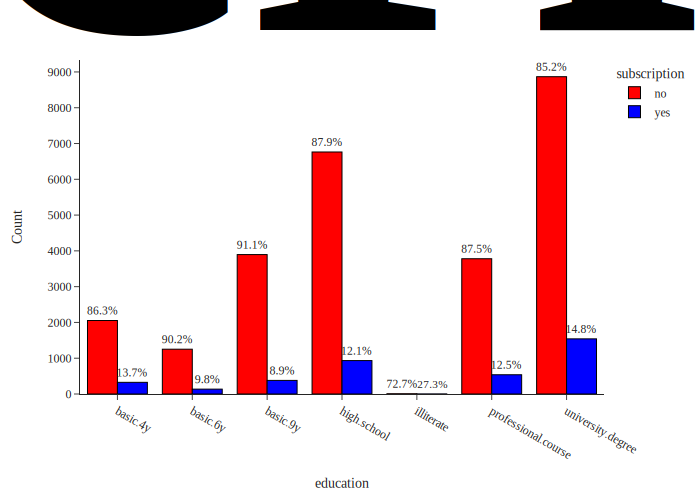

In [19]:
a = df.groupby(['education', 'subscription'], as_index=False)['age'].count().rename(columns={'age': 'Count'})
a['percent'] = round(a['Count'] * 100 / a.groupby('education')['Count'].transform('sum'), 1)
a['percent'] = a['percent'].apply(lambda x: '{}%'.format(x))

fig = px.bar(a, x='education', y='Count', text='percent', color='subscription', barmode='group', template='simple_white', color_discrete_map={'yes': '#0000ff', 'no': '#ff0000'})
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)), textposition="outside")
fig.update_layout(title_x=0.5, template='simple_white', showlegend=True, title_text='<b style="color:black; font-size:105%;">Distribution of Subscriptions By Education</b>', font_family="Times New Roman", title_font_family="Times New Roman")

#pio.write_image(fig, 'EDA/sub_edu.pdf')
fig.show("svg")

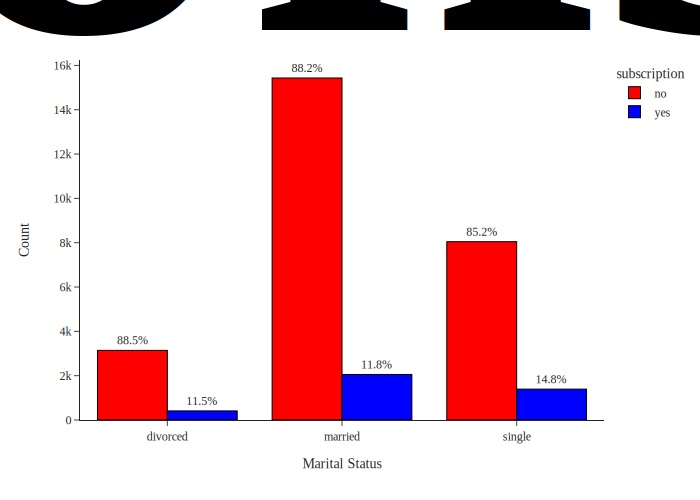

In [20]:
a = df.groupby(['marital', 'subscription'], as_index=False)['age'].count().rename(columns={'age': 'Count'})
a['percent'] = round(a['Count'] * 100 / a.groupby('marital')['Count'].transform('sum'), 1)
a['percent'] = a['percent'].apply(lambda x: '{}%'.format(x))

fig = px.bar(a, x='marital', y='Count', text='percent', color='subscription', barmode='group', 
             template='simple_white', color_discrete_map={'yes': '#0000ff', 'no': '#ff0000'})
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)), textposition="outside")
fig.update_layout(title_x=0.5, template='simple_white', showlegend=True, 
                  title_text='<b style="color:black; font-size:105%;">Distribution of Subscriptions Based On Marital Status</b>',
                   xaxis_title='Marital Status',font_family="Times New Roman", title_font_family="Times New Roman")

#pio.write_image(fig, 'EDA/sub_mar.pdf')
fig.show("svg")

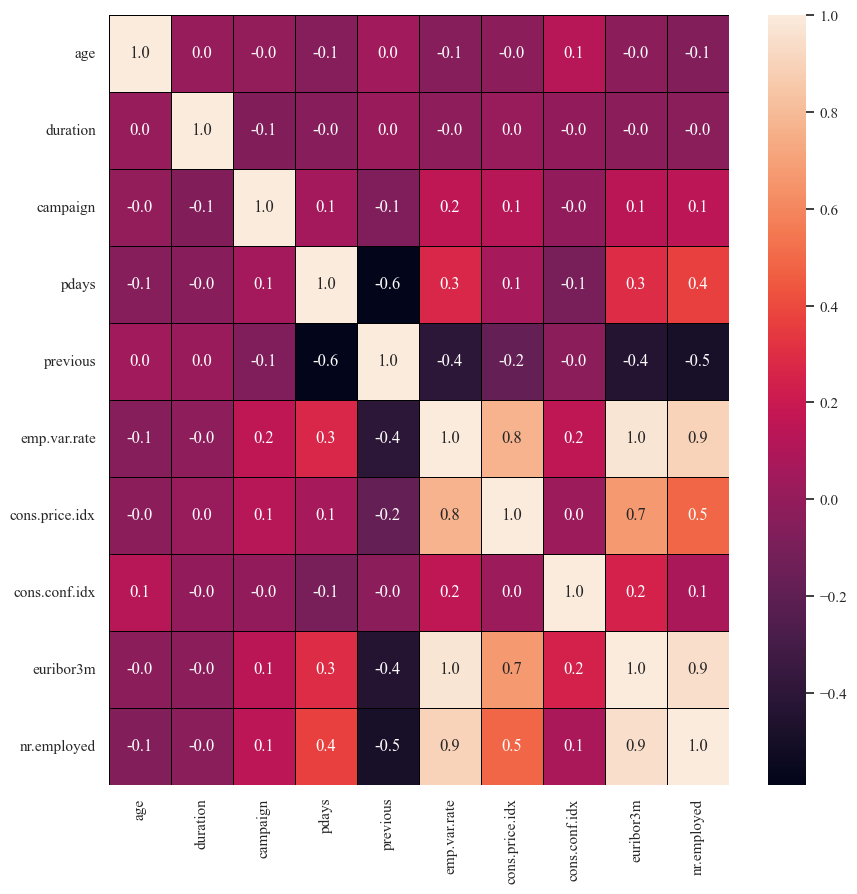

In [229]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,linecolor="black",fmt=".1f",ax=ax)
plt.savefig('EDA/corr.pdf')
plt.show()

# THE END 